In [1]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
LW=5 # linewidth
MS=10 # markersize

# Particle filtering
Alex Gorodetsky, November 2020, 2021, 2022

In this notebook we will implement and describe the particle filter. 

## Empirical distributions
Recall that the particle filter is an importance sampling technique. It allows for estimating of expectations with respect to the smoothing distribution as
\begin{equation}
\mathbb{E}\left[g(X_0, \ldots, X_{n}) \mid \mathcal{Y}_n\right] \approx \sum_{i=1}^N w_n^{(i)} g(x_{0}^{(i)}, \ldots, x_{n}^{(i)})
\end{equation}
where $$\sum_{i=1}^{N} w_{n}^{(i)} = 1.$$ so that we can effectively view this approximation as exact with respect to an empirical density
\begin{equation}
P(X_0, \ldots, X_{n} \mid \mathcal{Y}_n) \approx \sum_{i=1}^N w_{n}^{(i)} \delta_{\mathcal{X}_n^{(i)}}(X_0,\ldots,X_{n})  = \hat{P}(X_0, \ldots, X_{n} \mid \mathcal{Y}_n) 
\end{equation}
where  $\mathcal{X}_n^{(i)} = (x_{0}^{(i)}, x_{1}^{(i)}, \ldots, x_{n}^{(i)}).$ To be even more concrete, an empirical distribution is essentially representing a **discrete random variable** that only takes values given by the samples $\mathcal{X}_n^{(i)}$ with probability $w_{n}^{(i)}$.

One nice thing about empirical distirbutions is that they are easy to marginalize -- so that the filtering distribution is simply

\begin{equation}
\hat{P}(X_n \mid \mathcal{Y}_n) = \sum_{i=1}^N w_{n}^{(i)} \delta_{x_n^{(i)}}(X_{n}).
\end{equation}

### Resampling
One useful thing to do with empirical distributions is to be able to **resample** them -- which means generate new independent samples from the discrete random variables. In this way the resulting samples form an empirical distribution with equal weights themselves.

In [2]:
def resample(Nsamples, samples, weights):
    """Generate *Nsamples* samples from an empirical distribution defined by *samples* and *weights*

    Inputs
    ------
    Nsamples: integer, number of samples to generate
    samples: (N, d) array of N samples of dimension d that form the empirical distribution
    weights: (N, ) array of N weights

    Returns
    --------
    samples_out: (Nsamples, d) new samples
    weights_out: (Nsamples, ) new weights equal to 1 / N
    """

    N = samples.shape[0]  # get number of points that make up the empirical distribution
    rr = np.arange(N) # get an ordered set of numbers from 0 to N-1

    # Randomly choose the integers (with replacement) between 0 to N-1 with probabilities given by the weights
    samp_inds = np.random.choice(rr, Nsamples, p=weights)

    # subselect the samples chosen
    samples_out = samples[samp_inds, :]

    # return uniform weights
    weights_out = np.ones((Nsamples))/Nsamples
    return samples_out, weights_out

### Statistics computation

Next we want to be able to compute statistics of the distribution from the samples. For the purposes of filtering we will only use the mean and standard deviations of each state in the filtering distribution. These are given by
\begin{equation}
\mu = \mathbb{E}\left[X_n \mid \mathcal{Y}_n \right] \approx \sum_{i=1}^N w_{n}^{(i)} x_{n}^{(i)}
\end{equation}
\begin{equation}
\sigma = \sqrt{\mathbb{V}\text{ar}\left[X_n \mid \mathcal{Y}_n \right]} \approx \sqrt{\sum_{i=1}^N w_{n}^{(i)} \left(x_{n}^{(i)} -  \mu\right)^2 }
\end{equation}

In [3]:
def compute_mean_std(samples, weights):
    """Compute the mean and standard deviation of multiple empirical distirbution.

    Inputs
    ------
    samples: (N, d, m) array of samples defining the empirical distribution
    weights: (N, m) array of weights

    Returns
    -------
    means: (m, d) array of means
    stds: (m, d) array of standard deviations

    Notes
    -----
    m is the number of empirical distributions
    """

    N, d, m = samples.shape
    means = np.zeros((m, d))
    stds = np.zeros((m, d))
    for ii in range(m):
        means[ii, :] = np.dot(weights[:, ii], samples[:, :, ii])
        stds[ii, :] = np.sqrt(np.dot(weights[:, ii], (samples[:, :, ii] - np.tile(means[ii, :], (N, 1)))**2))
    return means, stds

## Algorithm

We are now ready to code up the algorithm. We begin by coding a single step of the particle filter, that is a step between observations.

In [4]:
def step(prop, proppdf, current_samples, current_weights, likelihood, data, propagator):
    """
    Propagate a particle filter

    Inputs
    --------
    prop            - proposal function (current_state, data)
    proppdf         - proposal function logpdf
    current_samples - ensemble of samples
    current_weights - ensemble of weights
    likelihood      - function to evaluate the log likelihood (samples, data)
    data            - Observation
    propagator      - dynamics logpdf

    @returns samples and weights after assimilating the data
    """
    #new_samples = np.zeros(current_samples.shape)
    #new_weights = np.zeros(current_weights.shape)

    new_samples = prop(current_samples, data)
    new_weights = likelihood(new_samples, data) + propagator(new_samples, current_samples) - \
                            proppdf(new_samples, current_samples, data)
    new_weights = np.exp(new_weights) * current_weights
    #for ii in range(new_samples.shape[0]):
    #    new_samples[ii, :] = prop(current_samples[ii, :], data)
    #    new_weights[ii] = np.exp(likelihood(new_samples[ii, :], data) +
    #                                propagator(new_samples[ii, :], current_samples[ii, :]) -
    #                                proppdf(new_samples[ii, :], current_samples[ii, :], data))
    #    new_weights[ii] *= current_weights[ii]

    # normalize weights
    new_weights = new_weights / np.sum(new_weights)
    return new_samples, new_weights

Next we create the "outer loop" with all necessary components

In [5]:
def particle_filter(data, prior_mean, prior_cov,
                    prop, proppdf, likelihood, propagator,
                    nsamples=1000, resampling_threshold_frac=0.1):
    """Particle Filter

    Inputs
    -------
    data: (nsteps, m) array of data points, N is the time index, m is the dimensionality of the data
    prior_mean: (d), prior mean
    prior_cov: (d, d), prior mean
    Nsamples: integer, number of samples in the empirical distribution
    resampling_threshold_frac: float between 0 and 1 indicating to resample when effective sample size below frac of nsamples

    Returns
    -------
    samples: (nsamples, d, nsteps)
    weights: (nsamples, nsteps)
    eff: (nsamples), effective sample size

    Notes
    -----
    For documentation of prop, proppdf, likelihood, and propagator -- see the step function
    """

    d = prior_mean.shape[0]
    nsteps = data.shape[0]

    # Allocate memory
    samples = np.zeros((nsamples, d, nsteps+1))
    weights = np.zeros((nsamples, nsteps+1))
    eff = np.zeros((nsteps+1)) # keep track of effective sample size at each step


    # Generate initial samples from the prior
    L = np.linalg.cholesky(prior_cov)
    samples[:, :, 0] = np.tile(prior_mean, (nsamples, 1))+ np.dot(L, np.random.randn(d, nsamples)).T
    weights[:, 0] = 1.0 / nsamples # all weights are equal because of independent sampling from prior
    eff[0] = nsamples

    resamp_threshold = int(nsamples * resampling_threshold_frac)

    for ii in range(1, nsteps+1):
        samples[:, :, ii], weights[:, ii] = step(prop,  proppdf, samples[:, :, ii-1], weights[:, ii-1],
                                                 likelihood, data[ii-1, :], propagator)
        # compute the effective sample size
        eff[ii] = 1.0 / np.sum(weights[:, ii]**2)

        if ii % 50 == 0:
            print("eff = ", ii, eff[ii])
        #print("eff/emean = ", eff[ii], means[ii, :])

        # resample if effective sample size is below threshold
        if eff[ii] < resamp_threshold:
            samples[:, :, ii], weights[:, ii] = resample(nsamples, samples[:, :, ii], weights[:, ii])


    return samples, weights, eff

## Demo problem

We will be testing the algorithm on the dynamics of a nonlinear pendulum discretized using forward euler. The observation operator is nonlinear.  This is almost what you need for your projects, however in your projects you wont observe at every time step.

In [6]:
def pendulum_dyn(current_state, dt=0.1):
    """Pendulum dynamics

    Inputs
    ------
    Current_state : either (2,) or (N, 2) for vectorized input
    """
    if current_state.ndim == 1:
        next_state = np.zeros((2))
        next_state[0] = current_state[0] + dt * current_state[1]
        next_state[1] = current_state[1] - dt * 9.81 * np.sin(current_state[0])
    else: # multiple inputs
        next_state = np.zeros(current_state.shape)
        next_state[:, 0] = current_state[:, 0] + dt * current_state[:, 1]
        next_state[:, 1] = current_state[:, 1] - dt * 9.81 * np.sin(current_state[:, 0])
    return next_state

def observe(current_state):
    if current_state.ndim == 1:
        out = np.zeros((1))
        out[0] = np.sin(current_state[0])
    else:
        out = np.zeros((current_state.shape[0], 1))
        out[:, 0] = np.sin(current_state[:, 0])
    return out

### Data generation

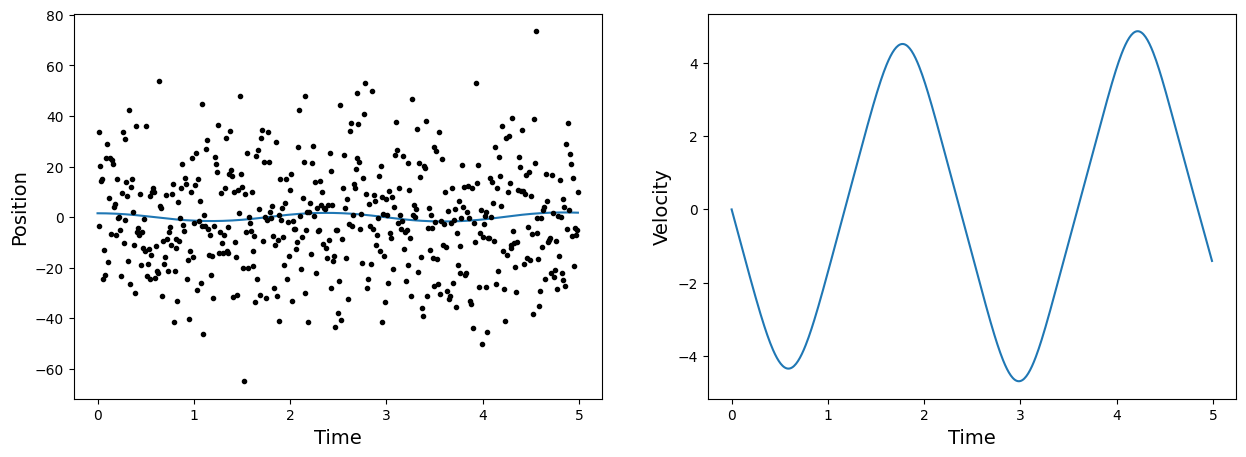

In [7]:
x0 = np.array([1.5, 0])
dt = 0.01
Nsteps = 500
true = np.zeros((Nsteps, 2))
true[0, :] = x0
times = np.arange(0, Nsteps*dt, dt)
data = np.zeros((Nsteps-1, 1))
ns = 1.0 # standard deviation of noise
# ns = 20.0
noise_var = ns*ns
for ii in range(1, Nsteps):
    true[ii, :] = pendulum_dyn(true[ii-1, :],dt=dt)
    data[ii-1] = observe(true[ii, :]) + np.random.randn()*ns

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].plot(times, true[:, 0])
axs[0].plot(times[1:], data, 'ko', ms=3)
axs[0].set_xlabel("Time", fontsize=14)
axs[0].set_ylabel("Position", fontsize=14)
axs[1].plot(times, true[:, 1])
axs[1].set_xlabel("Time", fontsize=14)
axs[1].set_ylabel("Velocity", fontsize=14)
plt.show()

### Bootstrap particle filter

We first setup the process noise, the proposals, and the likelihood

Recall the dynamics are 
\begin{equation}
X_{k} = \phi(X_{k-1}) + \xi, \quad \xi \sim \mathcal{N}(0, \Sigma)
\end{equation}

So the proposal is
\begin{equation}
\pi(X_k \mid X_{k-1}) = P(X_{k} \mid X_{k-1})  = \mathcal{N}(\phi(X_{k-1}), \Sigma)
\end{equation}

The likelihood comes from the observation model

\begin{equation}
Y_k = h(X_k) + \eta, \quad \eta \sim \mathcal{N}(0, \Gamma)
\end{equation}

so that 
\begin{equation}
P(Y_k \mid X_{k}) = \mathcal{N}(h(X_{k}), \Gamma)
\end{equation}

In [8]:
# Process noise
proc_var=0.5
proc_mat = np.zeros((2,2))
proc_mat[0, 0] = proc_var/3.0*dt**3
proc_mat[0, 1] = proc_var/2.0*dt**2
proc_mat[1, 0] = proc_var/2.0*dt**2
proc_mat[1, 1] = proc_var*dt
proc_mat_inv = np.linalg.pinv(proc_mat)
Lproc  = np.linalg.cholesky(proc_mat)

def proposal(current_state, data=None, dt=dt):
    """ Bootstrap Particle Filter the proposal is the dynamics!"""

    if current_state.ndim == 1:
        return pendulum_dyn(current_state, dt=dt) + np.dot(Lproc, np.random.randn(2))
    else:
        nsamples = current_state.shape[0]
        return pendulum_dyn(current_state, dt=dt) + np.dot(Lproc, np.random.randn(2, nsamples)).T

def proposal_logpdf(current, previous, data=None, proc_var=0.1):
    """ Bootstrap Particle Filter: the proposal is the dynamics"""
    nexts  = pendulum_dyn(previous, dt=dt)
    delta = nexts - current
    if current.ndim == 1:
        return -0.5 * np.dot(delta, np.dot(proc_mat_inv, delta))
    else:
        return -0.5 * np.sum(delta * np.dot(delta, proc_mat_inv.T), axis=1)

def likelihood(state, data, noise_var=noise_var):
    """Gaussian Likelihood through nonlinear model"""
    dpropose = observe(state)
    delta = dpropose - data
    if state.ndim == 1:
        return -0.5 * np.dot(delta, delta) / noise_var
    else:
        return -0.5 * np.sum(delta * delta, axis=1) / noise_var

Next we setup the prior and run the algorithm

In [9]:
prior_mean = true[0, :] # start at the truth -- this is obviously not possible in reality
prior_cov = np.eye(2) # identity covariance

samples, weights, eff =  particle_filter(data, prior_mean, prior_cov,
                                            proposal, proposal_logpdf, likelihood, proposal_logpdf,
                                            nsamples=1000, resampling_threshold_frac=0.1)

eff =  50 970.8634031396477
eff =  100 870.1707270973208
eff =  150 876.7130477597827
eff =  200 903.185523925252
eff =  250 913.8473642014129
eff =  300 845.0282316871835
eff =  350 829.9702551735302
eff =  400 669.8019540192719
eff =  450 662.6388361592652


We now look at the effective sample size and the filtering distribution

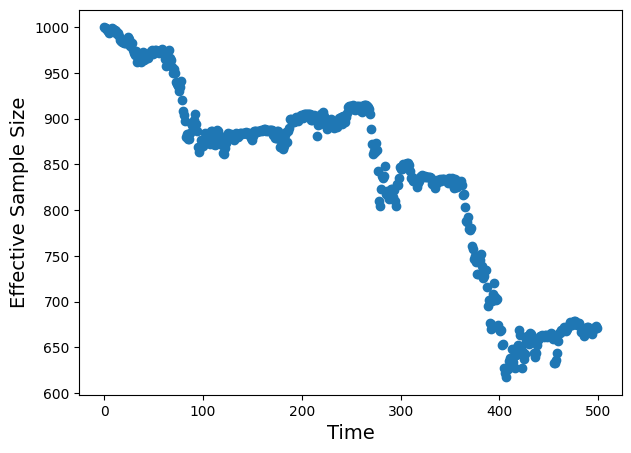

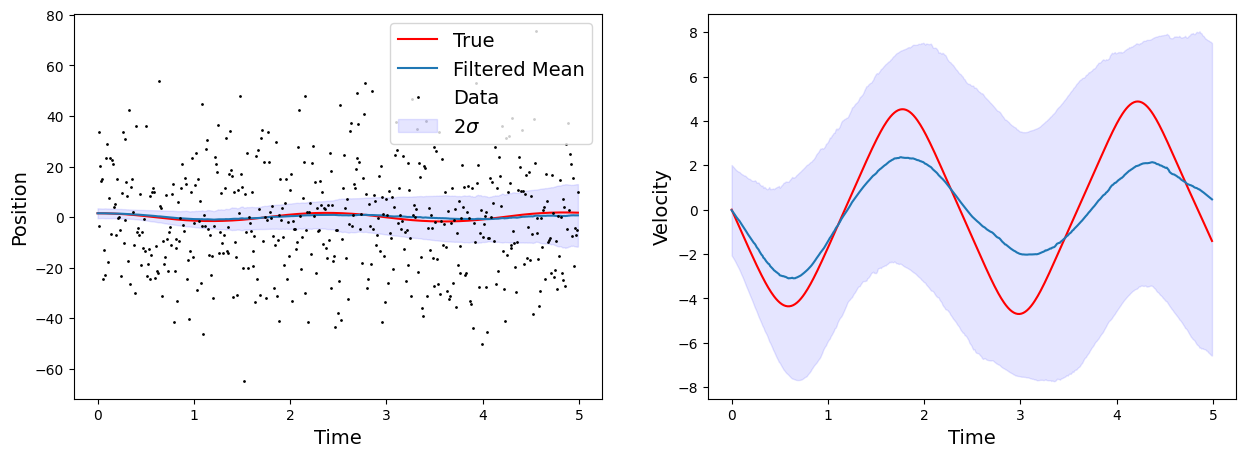

In [10]:
plt.figure(figsize=(7,5))
plt.plot(eff, 'o')
plt.xlabel("Time", fontsize=14)
plt.ylabel("Effective Sample Size", fontsize=14)
plt.show()

means, stds = compute_mean_std(samples, weights)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(times, true[:, 0],'-r', label='True')
axs[0].plot(times, means[:, 0], '-', label='Filtered Mean')
axs[0].plot(times[1:], data[:, 0], 'ko', ms=1, label='Data')
axs[0].fill_between(times, means[:, 0] - 2 * stds[:, 0], means[:, 0]+2*stds[:, 0], color='blue', alpha=0.1, label=r'$2\sigma$') 
axs[0].set_xlabel('Time',fontsize=14)
axs[0].set_ylabel('Position', fontsize=14)
axs[0].legend(fontsize=14)

axs[1].plot(times, true[:, 1],'-r', label='True')
axs[1].plot(times, means[:, 1], '-', label='Filtered Mean')
axs[1].fill_between(times, means[:, 1] - 2 * stds[:, 1], means[:, 1]+2*stds[:, 1], color='blue', alpha=0.1, label=r'$2\sigma$') 
axs[1].set_xlabel('Time',fontsize=14)
axs[1].set_ylabel('Velocity', fontsize=14)

plt.show()

Lets now look at the actual joint distributions at several time steps

In [11]:
def plot_2d(weights, samples, xlim, ylim):
    """A function to plot an empirical distribution"""
    Nsamples = 3000
    s, w = resample(Nsamples, samples, weights) # resample to obtain equal weights

    xspace = np.linspace(xlim[0], xlim[1],100)
    yspace = np.linspace(ylim[0], ylim[1],100)
    XX, YY = np.meshgrid(xspace, yspace)

    fig, axs = plt.subplots(1,1)

    positions = np.vstack([XX.ravel(), YY.ravel()])
    values = np.vstack([s[:, 0], s[:, 1]])
    kernel = stats.gaussian_kde(values) # kernel density estimate to get contours
    f = np.reshape(kernel(positions).T, XX.shape)
    axs.contour(XX, YY, f,)
    axs.plot(s[:, 0], s[:, 1], 'x', color='grey', alpha=0.1)
    axs.set_xlabel("angle")
    axs.set_ylabel("angular rate")

    return fig, axs

0 (2, 500)
25 (2, 500)
50 (2, 500)
75 (2, 500)
100 (2, 500)
125 (2, 500)
150 (2, 500)
175 (2, 500)
200 (2, 500)
225 (2, 500)
250 (2, 500)
275 (2, 500)
300 (2, 500)
325 (2, 500)
350 (2, 500)
375 (2, 500)
400 (2, 500)
425 (2, 500)
450 (2, 500)
475 (2, 500)


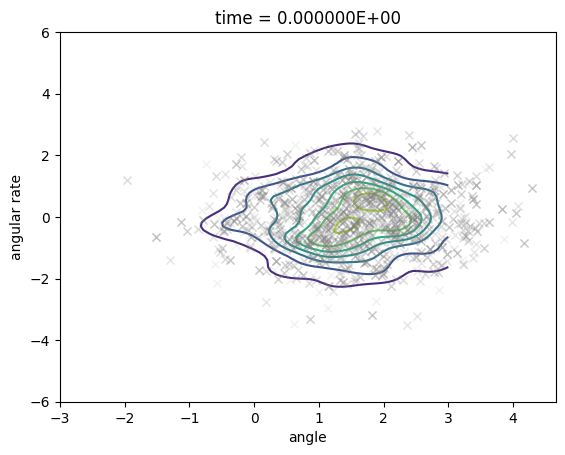

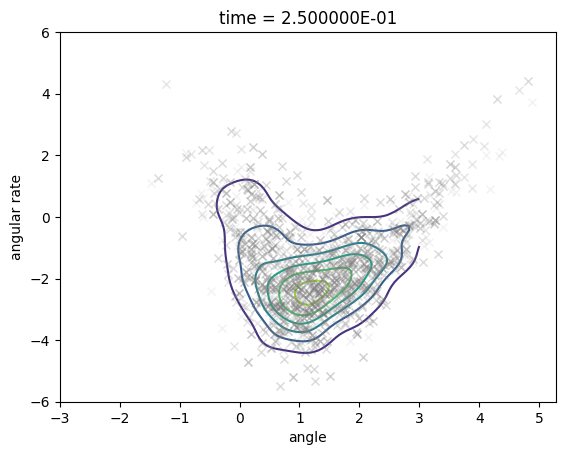

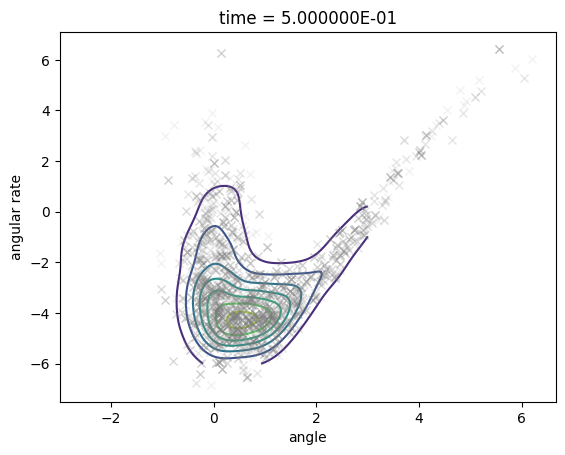

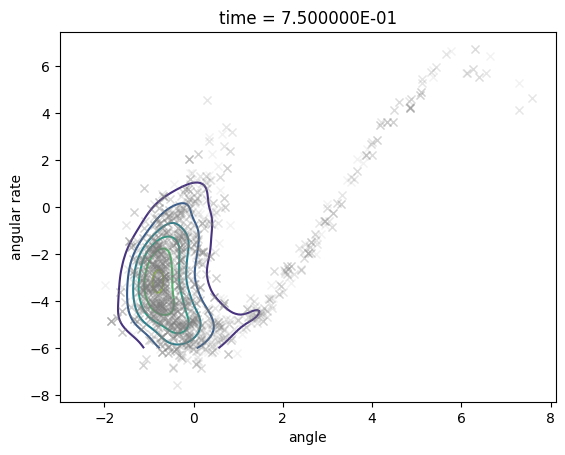

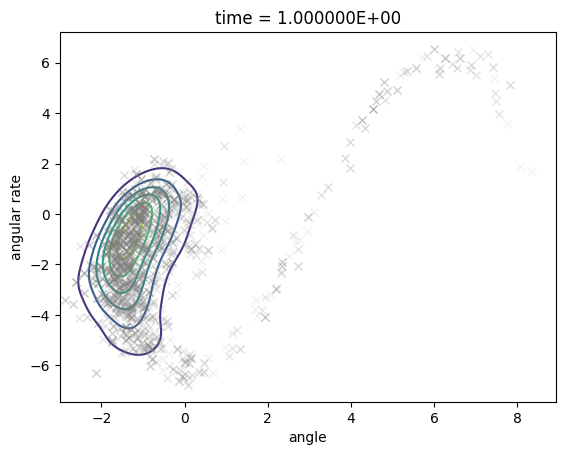

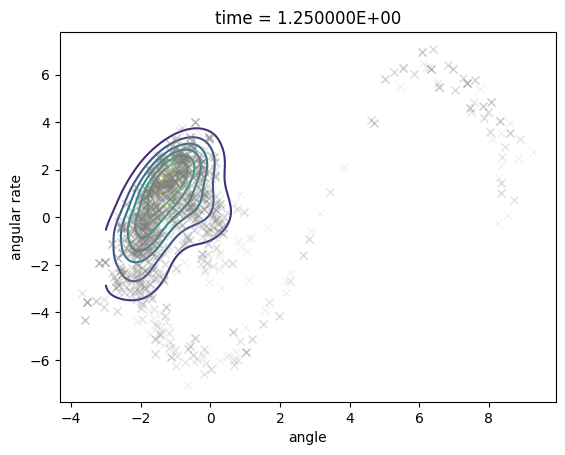

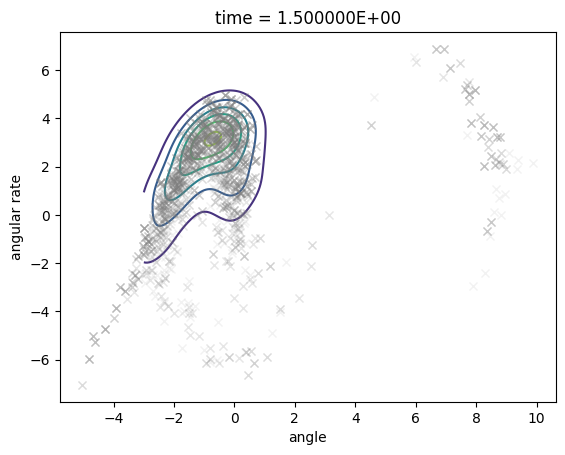

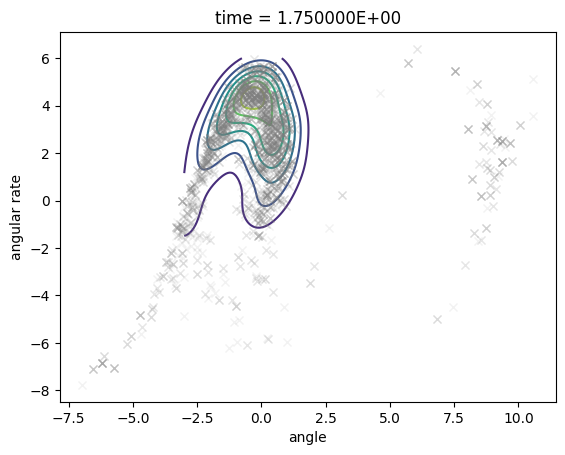

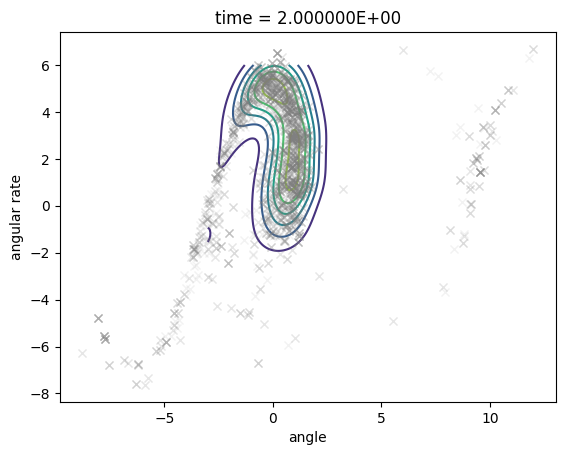

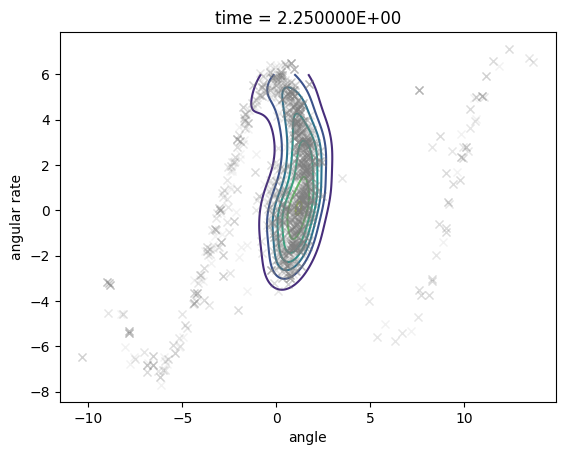

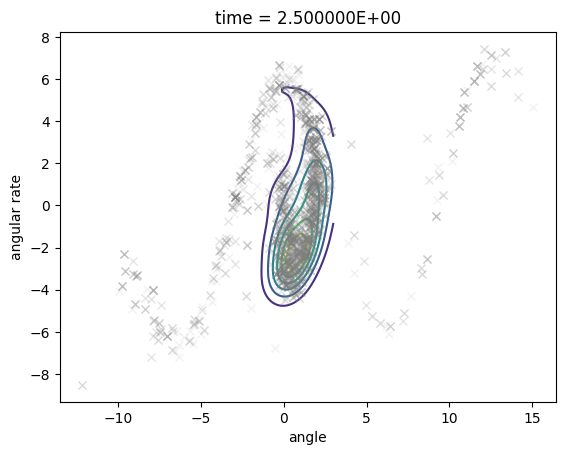

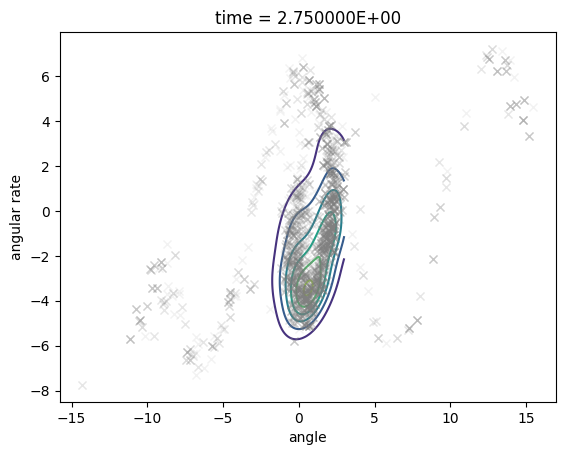

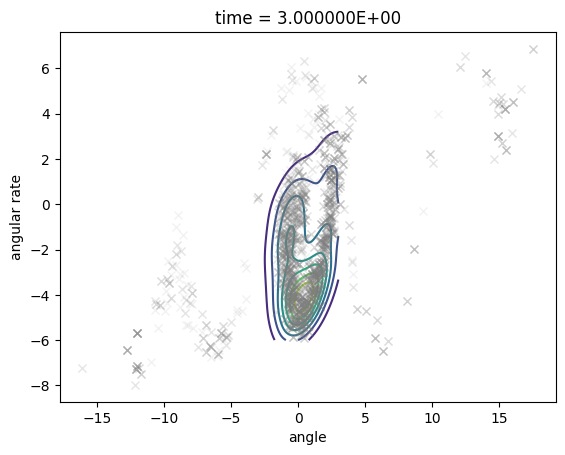

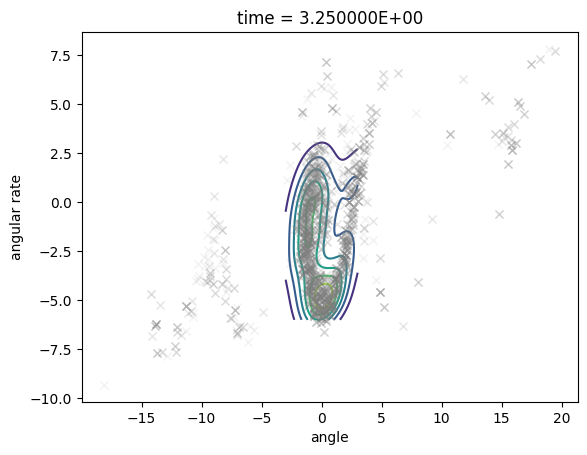

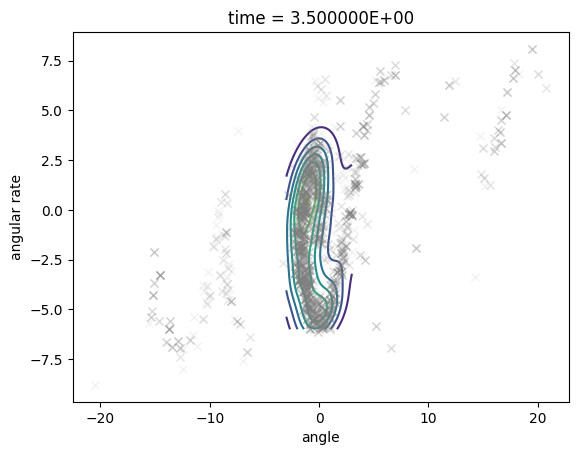

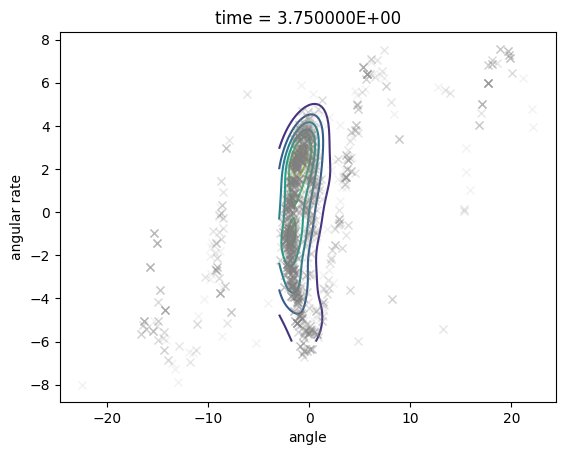

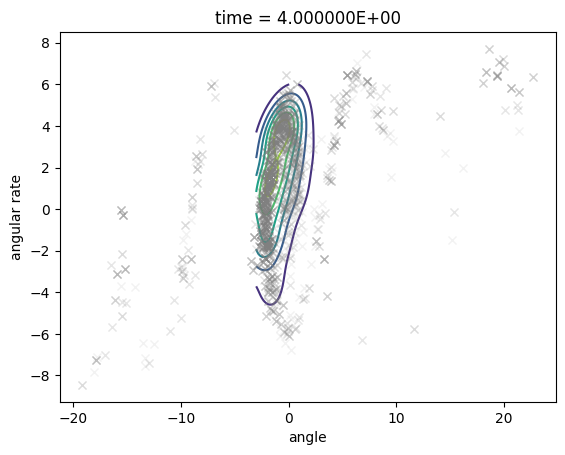

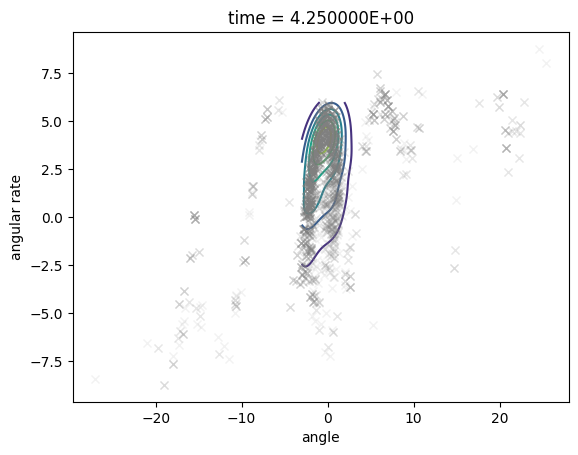

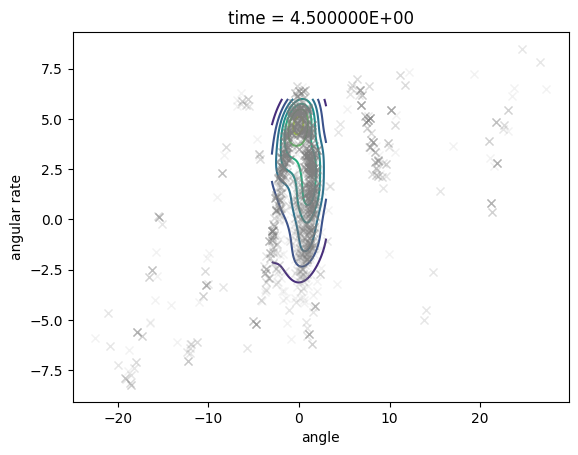

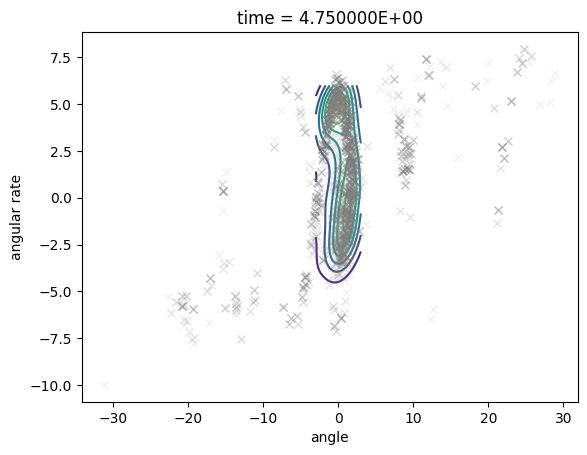

In [12]:
xlim = [-3, 3]
ylim = [-6, 6]
N, d = means.shape
for ii in range(N):
    if ii % 25 == 0:
        print(ii, samples[ii].shape)
        fig, axs = plot_2d(weights[:, ii], samples[:, :, ii], xlim, ylim)
        axs.set_title("time = {:5E}".format(times[ii]))